In [1]:
import pandas as pd
import numpy as np
np.random.seed(42)
pd.set_option('display.max_columns', 50)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split

from read_datasets import DATA_PATH
from multiprocessing import Pool # for reading the CSVs faster

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

TESTING = False # Use this run with less data
CV = 10 # Amount of folds in cross validation
N_JOBS = 5

# Models to use
MODELS = [ 
    KNeighborsClassifier(n_neighbors=3), 
    KNeighborsClassifier(n_neighbors=5), 
    KNeighborsClassifier(n_neighbors=7),
    MLPClassifier(solver="sgd", hidden_layer_sizes=(16,)),
    MLPClassifier(solver="sgd", hidden_layer_sizes=(16,), momentum=1),
    MLPClassifier(solver="sgd", hidden_layer_sizes=(16,), momentum=0.7, 
                  learning_rate_init=0.01),
    MLPClassifier(solver="sgd", hidden_layer_sizes=(16, 12, ), momentum=1),
]

NAMES = ["3-NN", "5-NN", "7-NN", "MLP-1L", "MLP-1L-Mm", "MLP-1L-lr",
         "MLP-2L"]

Using TensorFlow backend.


# Read the data

In [2]:
def my_read_csv(filename):
    # Helper function for the parellel load_csvs
    return pd.read_csv(filename)

def load_csvs(prefix):
    """Reads and joins all our CSV files into one big dataframe.
    We do it in parallel to make it faster, since otherwise it takes some time.
    Idea from: https://stackoverflow.com/questions/36587211/easiest-way-to-read-csv-files-with-multiprocessing-in-pandas
    
    """
    # set up your pool
    pool = Pool() 
    file_list = [f"{DATA_PATH}/{prefix}{idx}.csv" for idx in range(1, 21)]
    df_list = pool.map(my_read_csv, file_list)

    # reduce the list of dataframes to a single dataframe
    return pd.concat(df_list, ignore_index=True)

In [3]:
%%time
icmc_df = load_csvs("icmc")
original_df = load_csvs("original")

if TESTING:
    icmc_df = icmc_df.sample(n=100)
    original_df = original_df.sample(n=100)
    CV = 2
    MODELS = MODELS[:3]
    NAMES = NAMES[:3]

CPU times: user 700 ms, sys: 247 ms, total: 947 ms
Wall time: 24.8 s




- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

In [4]:
precisions = []

def calculate_average_precision(confusion_matrix):    
    """ Calculate Average Precision on Multiclass Dataset
    
    We use the formula: 
        Precision[i] = TP[i] / (TP[i] + FP[i] = Sum of Column[i])
    """ 
    # Helper function to deal with division by 0
    def weird_division(n, d):
        return n / d if d else 0

    [precisions.append(weird_division(confusion_matrix[i][i], 
                                      np.sum(confusion_matrix, axis=0)[i])) 
         for i in range(confusion_matrix.shape[0])]        
    return np.mean(precisions)

# Classify without processing

In [5]:
def run_models(x, y, processing="Nenhum", names=NAMES, models=MODELS, 
               result_cols=["Score", "Model", "Pré-Processamento"]):
    model_results = []
    all_results = pd.DataFrame(columns=result_cols)
    results = pd.DataFrame(columns=["Confusion_Matrix", "Accuracy", "Precision", "Model", "Pré-Processamento"])

    for model, name in zip(models, names):
        y_pred = cross_val_predict(model, x, y, cv=CV, n_jobs=N_JOBS)
        conf_mat = confusion_matrix(y, y_pred)

        acc = accuracy_score(y, y_pred)
        precision = calculate_average_precision(conf_mat)        

        results.loc[len(results)] = [conf_mat, acc, precision, name, processing]
        
        # By default, cross_val_score is stratified by Y automatically!
        mean_score = cross_val_score(model, x, y, scoring="accuracy", 
                                     cv=CV, n_jobs=N_JOBS).mean()
        model_results.append(mean_score)
        all_results.loc[len(all_results)] = [mean_score, name, processing]
    return all_results, results

In [6]:
%%time
icmc_results, icmc_matrix = run_models(icmc_df.drop(columns="target"), 
                                       icmc_df["target"])

/home/bcoelho/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/bcoelho/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/bcoelho/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/bcoelho/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  %

/home/bcoelho/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/bcoelho/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/bcoelho/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/bcoelho/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  %

CPU times: user 35.5 s, sys: 2.11 s, total: 37.6 s
Wall time: 15min 55s


In [7]:
%%time
original_results, original_matrix = run_models(original_df.drop(columns="target"), 
                                               icmc_df["target"])

/home/bcoelho/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/bcoelho/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/bcoelho/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/bcoelho/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  %

/home/bcoelho/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/bcoelho/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/bcoelho/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/bcoelho/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  %

/home/bcoelho/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/bcoelho/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/bcoelho/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/bcoelho/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  %

CPU times: user 5.71 s, sys: 1.11 s, total: 6.82 s
Wall time: 3min 14s


## Show results

In [8]:
# Fonte: https://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/
def plot_confusion_matrix(cm, name, dataset, file_prefix="orl", save=True):
    """Pretty print a confusion matrix in Python
    
    Parameters
    ----------
    cm : numpy.narray
        Confusion matrix generated 
        
    name : str
        Name of the confusion matrix
        
    dataset : str
            Name of the dataset used
    """
    plt.figure(figsize=(16,9))
    class_names = icmc_df["target"].unique()
    fig = sns.heatmap(cm, square=True, annot=True, fmt="d", cbar=False, 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{dataset}\nMatriz de Confusão: {name}')
    plt.ylabel('Classe Real')
    plt.xlabel('Classe Predita')    
    
    if save:
        fig = fig.get_figure()
        name  = f"pics/{file_prefix}-{name.replace('-', '')}-matrix.png".lower()
        fig.savefig(name)
    plt.show()

In [9]:
def plot_results(results, name, use_hue=False, y_name="Score", xlabel="Acurácia",
                file_prefix="orl", save=True):
    """Plots the results of a experiment
    
    Parameters
    ----------
    results : pd.DataFrame
        Should have the columns "Score", "Modelo", "Pré-Processamento"
        
    name : str
        Name of the data used
        
    use_hue : bool
            Weather or not to color by the column "Pré-Processamento"
    """
    if use_hue:
        fig = sns.barplot(y=y_name, x="Model", data=results, hue="Pré-Processamento")
    else:
        fig = sns.barplot(y=y_name, x="Model", data=results)
    plt.xlabel("Modelo")
    plt.xlabel(xlabel)
    plt.xticks(rotation=90)
    plt.title(f"{xlabel} entre os modelos para os dados {name}");
    
    # Save and show image
    if save:
        fig = fig.get_figure()
        name = f"pics/{file_prefix}-{y_name}.png".lower()
        fig.savefig(name)
    plt.show()

In [10]:
def plot_result(results, name, use_hue=False, file_prefix="orl", save=True):
    # Confusion Matrix
    for i in range(len(results)):
        plot_confusion_matrix(results["Confusion_Matrix"][i], 
                              results["Model"][i], name, file_prefix=file_prefix,
                             save=save)
    print()
    
    plot_results(results, name, use_hue=use_hue,
                 y_name="Accuracy", xlabel="Acurácia", file_prefix=file_prefix,
                 save=save)
    plot_results(results, name, use_hue=use_hue,
                 y_name="Precision", xlabel="Precisão", file_prefix=file_prefix,
                 save=save)


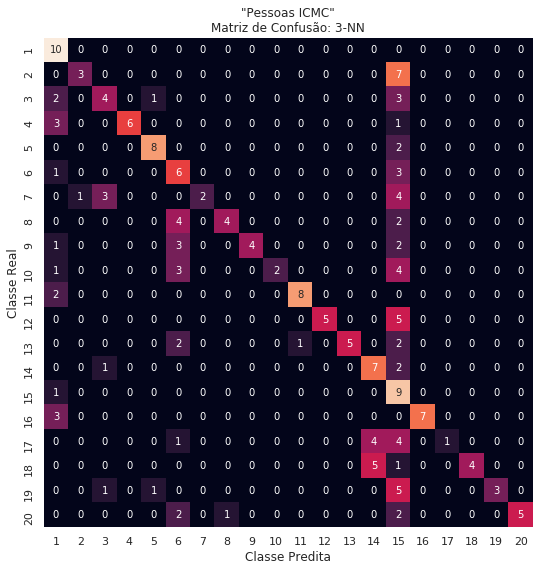

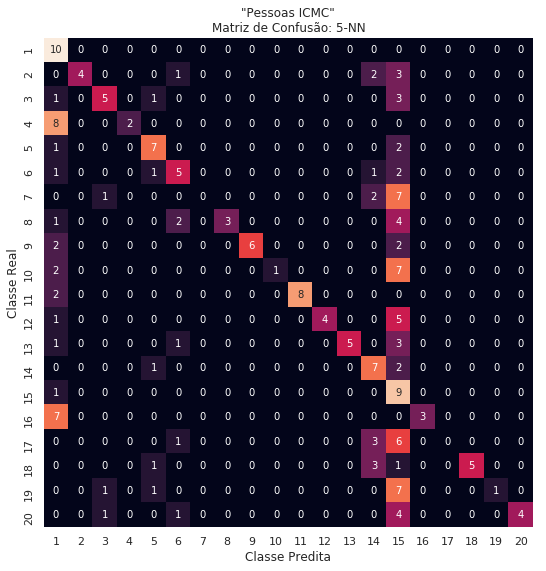

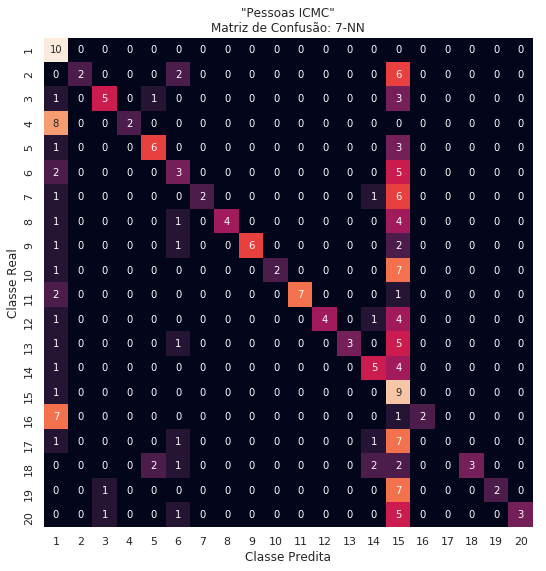

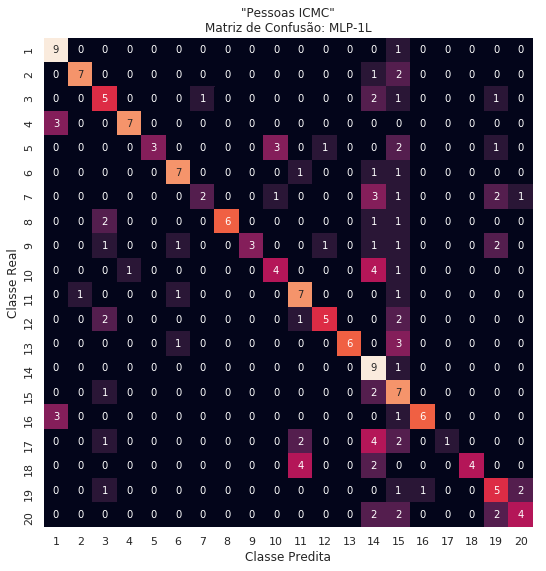

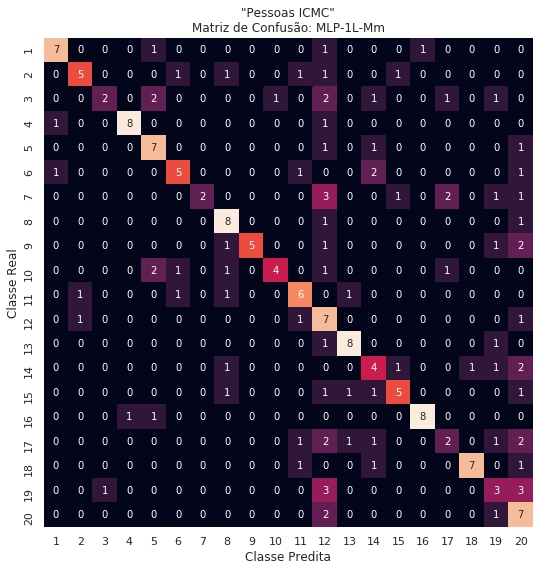

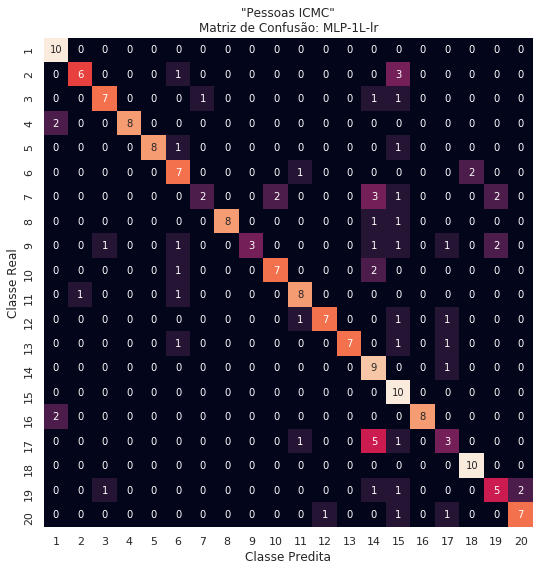

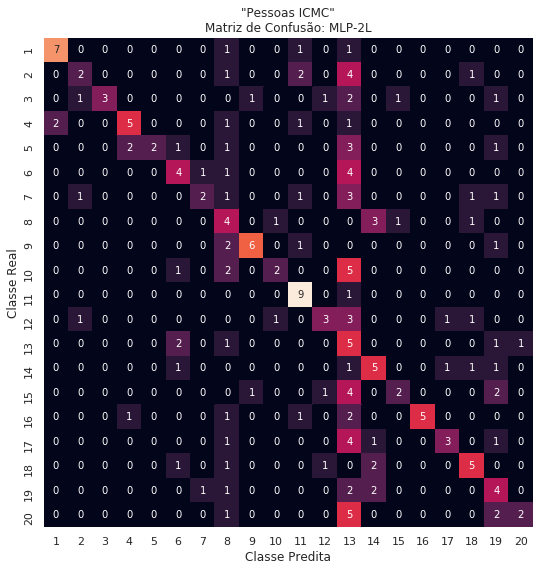

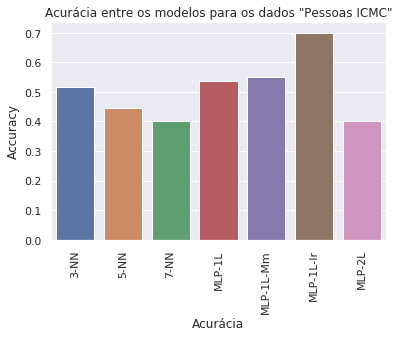

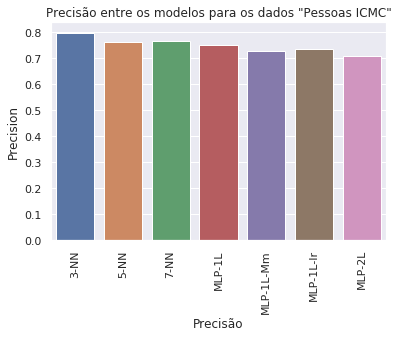

In [11]:
plot_result(icmc_matrix, "\"Pessoas ICMC\"", file_prefix="icmc_sem_proc")

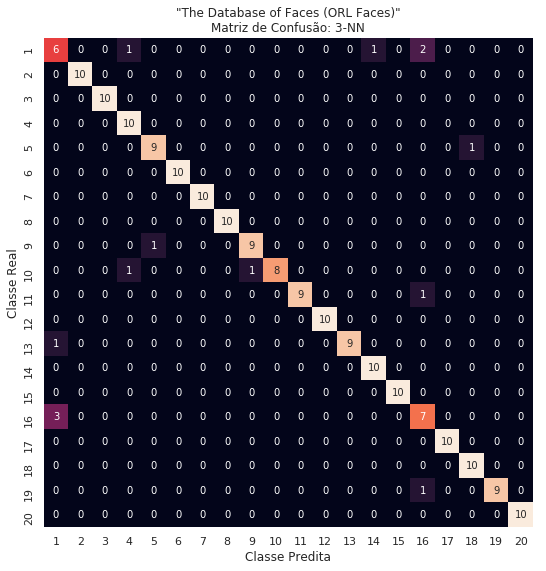

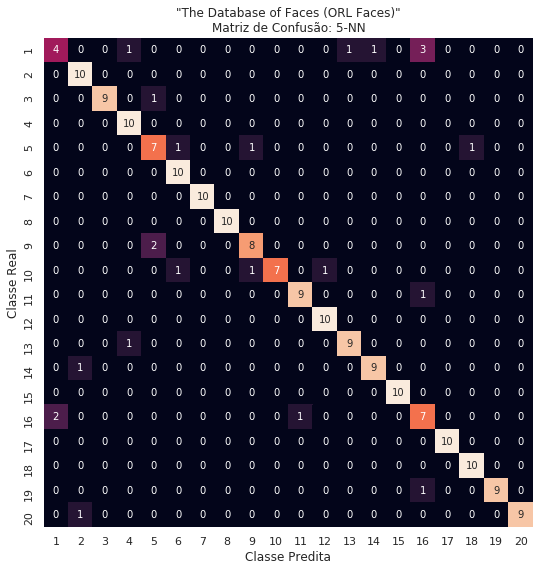

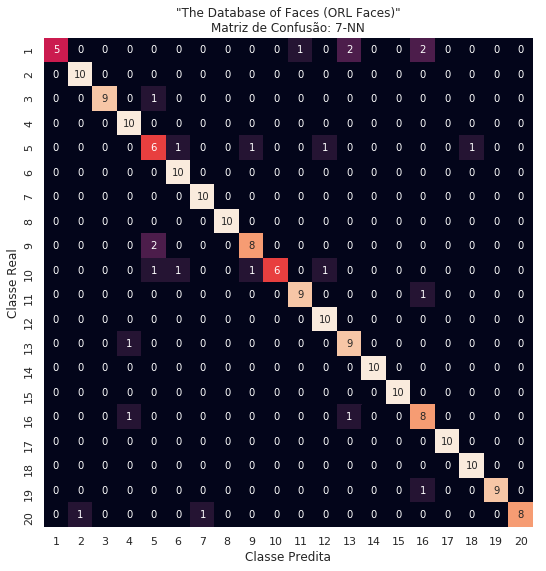

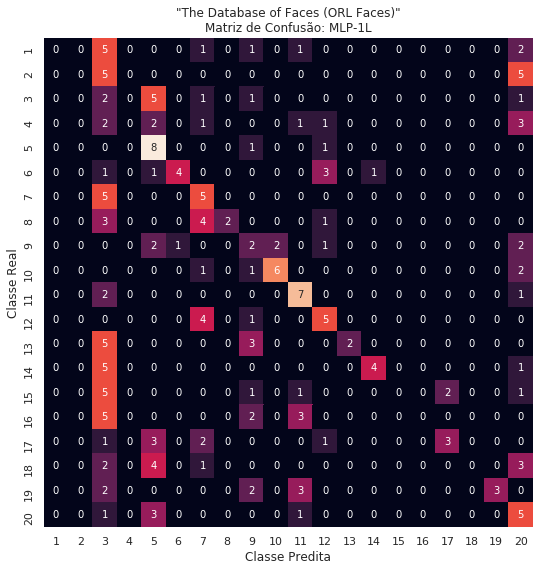

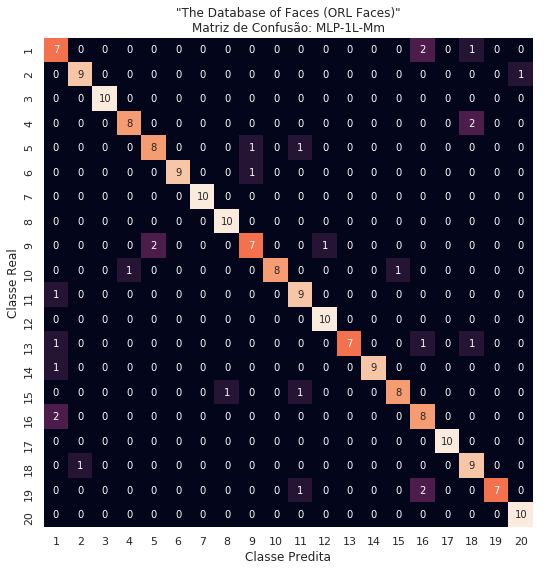

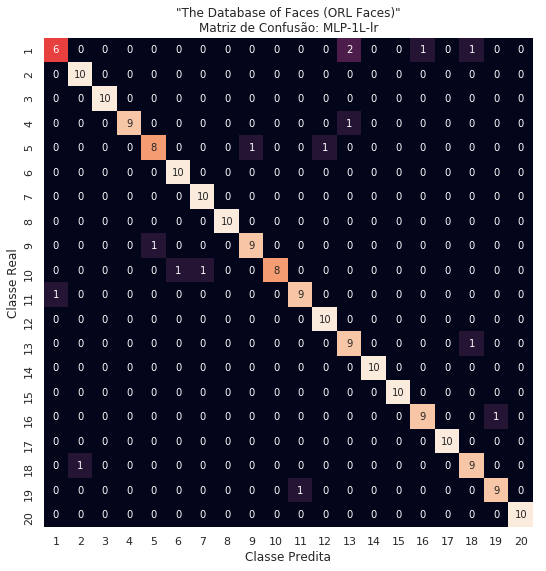

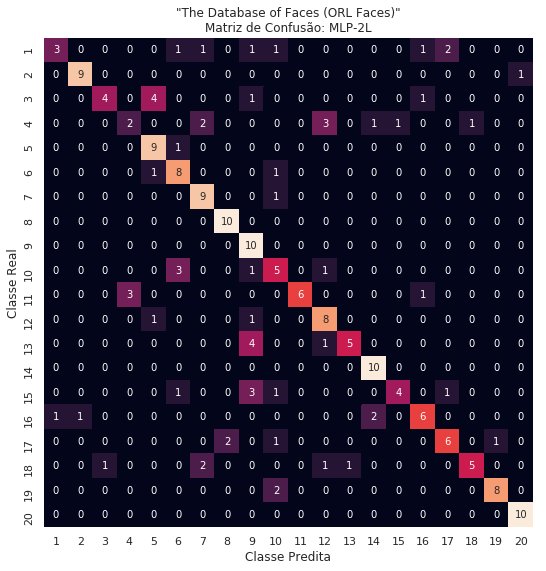

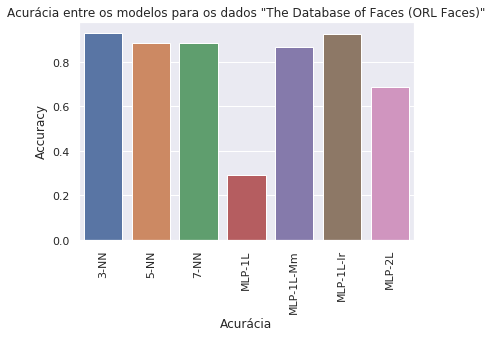

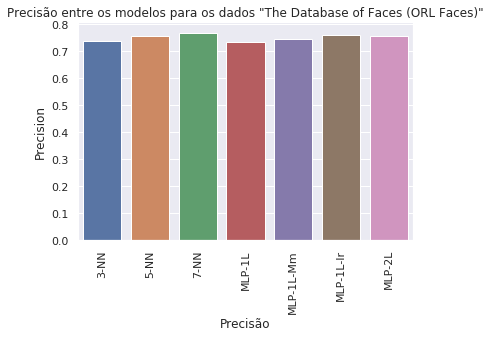

In [12]:
plot_result(original_matrix, "\"The Database of Faces (ORL Faces)\"",
           file_prefix="orl_sem_proc")

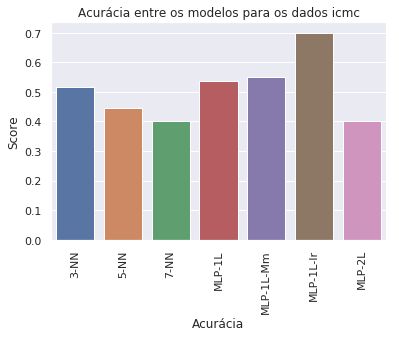

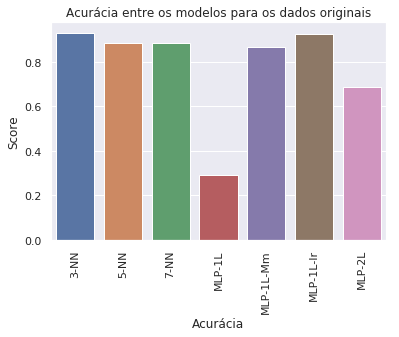

In [13]:
plot_results(icmc_results, "icmc", file_prefix="icmc", save=False)
plot_results(original_results, "originais", file_prefix="orl", save=False)

In [14]:
#icmc_results, icmc_matrix["A"]
icmc_matrix[['Accuracy', 'Precision', 'Model', 'Pré-Processamento']]

,Accuracy,Precision,Model,Pré-Processamento
0,0.515,0.798919,3-NN,Nenhum
1,0.445,0.760691,5-NN,Nenhum
2,0.400,0.765707,7-NN,Nenhum
3,0.535,0.750561,MLP-1L,Nenhum
4,0.550,0.728404,MLP-1L-Mm,Nenhum
5,0.700,0.734521,MLP-1L-lr,Nenhum
6,0.400,0.709827,MLP-2L,Nenhum


In [15]:
original_matrix[['Accuracy', 'Precision', 'Model', 'Pré-Processamento']]

,Accuracy,Precision,Model,Pré-Processamento
0,0.930,0.737897,3-NN,Nenhum
1,0.885,0.754621,5-NN,Nenhum
2,0.885,0.768879,7-NN,Nenhum
3,0.290,0.733739,MLP-1L,Nenhum
4,0.865,0.746027,MLP-1L-Mm,Nenhum
5,0.925,0.759989,MLP-1L-lr,Nenhum
6,0.685,0.756879,MLP-2L,Nenhum




- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Apply PCA

In [16]:
def apply_pca(data, pca_percentage=0.5):
    # We must use "full" for solver otherwise we can't use a percentage
    pca =  PCA(n_components=pca_percentage,  svd_solver="full") 
    new_data = pca.fit_transform(data.drop(columns="target"))
    new_data = pd.DataFrame(new_data)
    new_data["target"] = data["target"].copy(deep=True)
    
    print(f"Explicando {pca_percentage*100}% dos dados, o PCA encontrou os", 
         f"{len(pca.explained_variance_)} melhores autovetores\n\n")
    return new_data

In [17]:
%%time
original_pca = apply_pca(original_df)

Explicando 50.0% dos dados, o PCA encontrou os 17 melhores autovetores


CPU times: user 1.22 s, sys: 562 ms, total: 1.78 s
Wall time: 261 ms


In [18]:
%%time
icmc_pca = apply_pca(icmc_df)

Explicando 50.0% dos dados, o PCA encontrou os 49 melhores autovetores


CPU times: user 19.4 s, sys: 8 s, total: 27.4 s
Wall time: 4.01 s


In [19]:
icmc_results = icmc_results.append(run_models(icmc_pca.drop(columns="target"), 
                                              icmc_pca["target"], processing="PCA")[0],
                                   ignore_index=True)
icmc_matrix = icmc_matrix.append(run_models(icmc_pca.drop(columns="target"), icmc_pca["target"], processing="PCA")[1], ignore_index=True)


/home/bcoelho/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/bcoelho/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/bcoelho/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/bcoelho/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  %

/home/bcoelho/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/bcoelho/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/bcoelho/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/bcoelho/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  %

/home/bcoelho/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/bcoelho/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/bcoelho/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/bcoelho/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  %

/home/bcoelho/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/bcoelho/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/bcoelho/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/bcoelho/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  %

/home/bcoelho/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/bcoelho/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/bcoelho/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/bcoelho/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  %

In [20]:
original_results = original_results.append(run_models(original_pca.drop(columns="target"), 
                                              original_pca["target"], processing="PCA")[0],
                                   ignore_index=True)
original_matrix = original_matrix.append(run_models(original_pca.drop(columns="target"), original_pca["target"], processing="PCA")[1], ignore_index=True)

/home/bcoelho/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/bcoelho/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/bcoelho/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/bcoelho/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  %

/home/bcoelho/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/bcoelho/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/bcoelho/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/bcoelho/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  %

/home/bcoelho/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/bcoelho/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/bcoelho/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/bcoelho/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  %

/home/bcoelho/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/bcoelho/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/bcoelho/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/bcoelho/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  %

/home/bcoelho/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/bcoelho/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/bcoelho/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/bcoelho/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  %

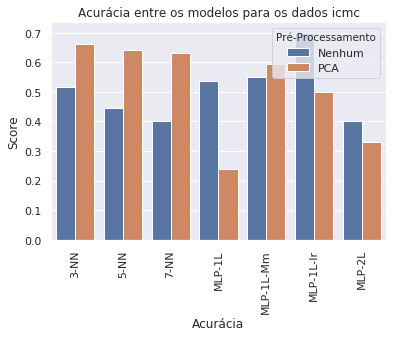

In [21]:
plot_results(icmc_results, name="icmc", use_hue=True, save=False)

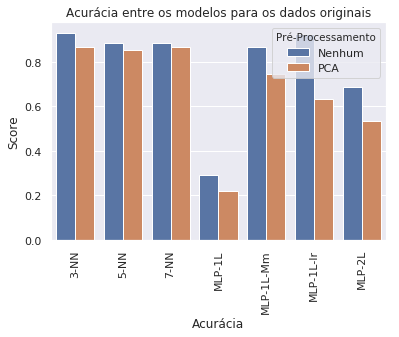

In [22]:
plot_results(original_results, name="originais", use_hue=True, save=False)

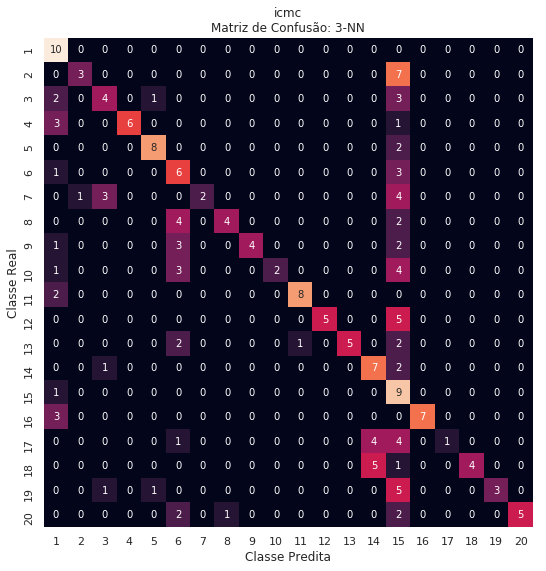

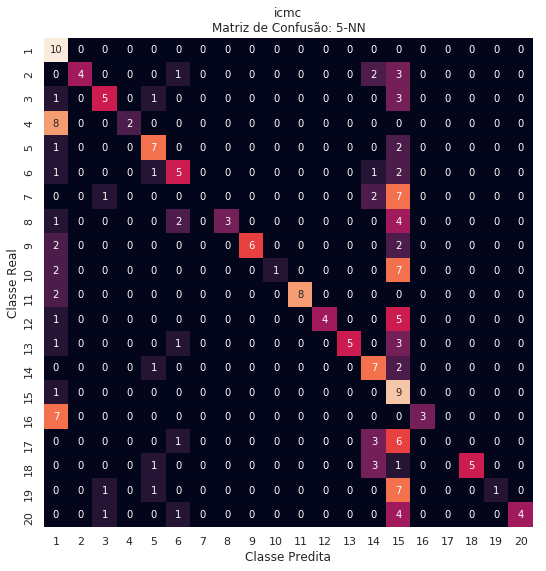

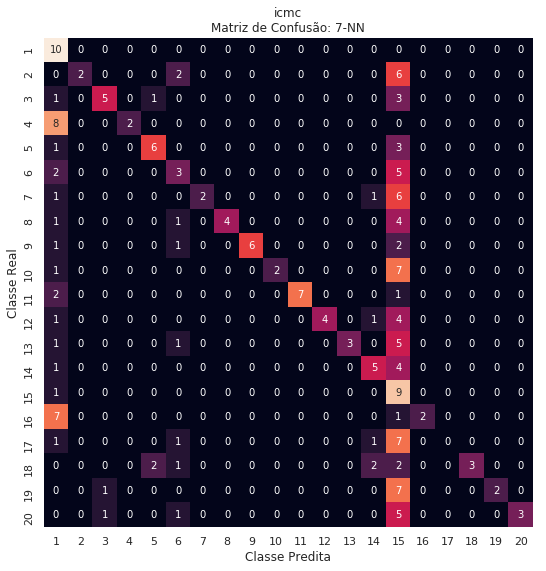

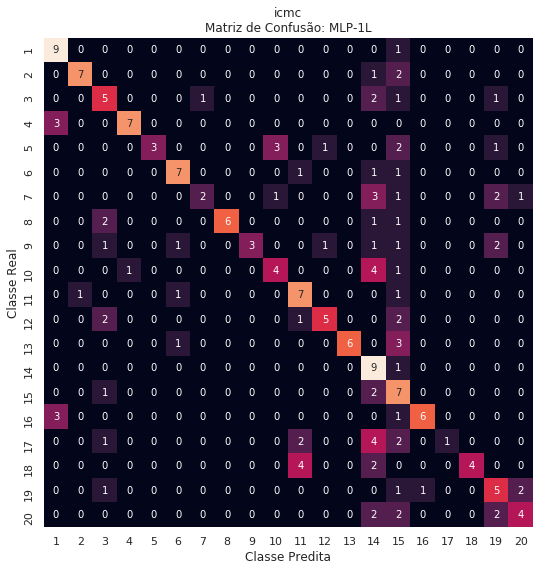

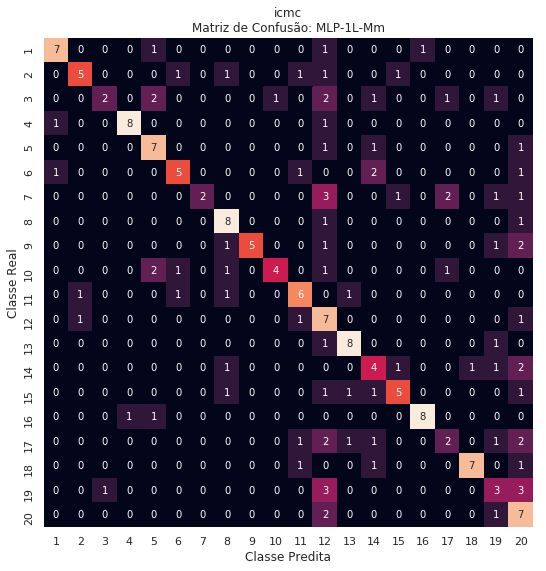

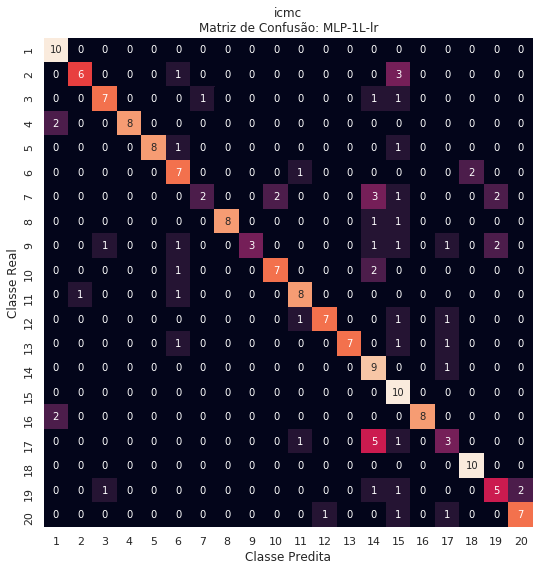

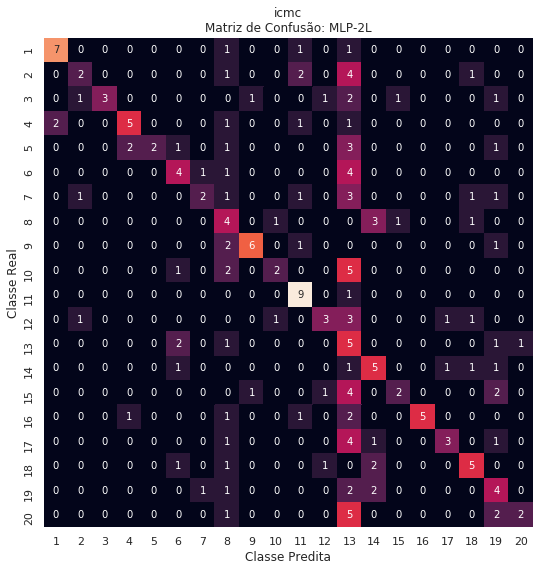

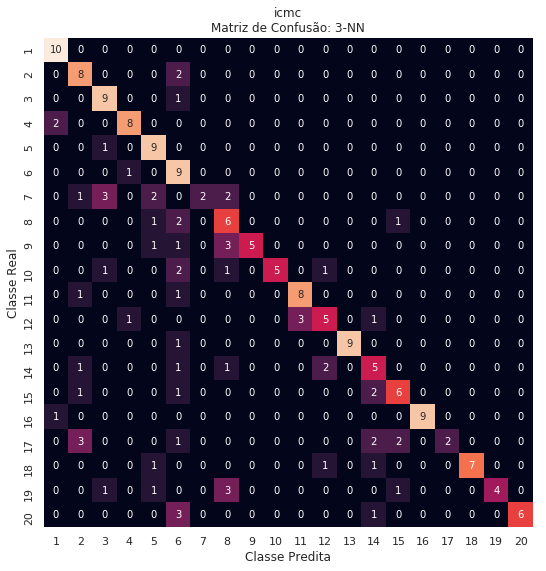

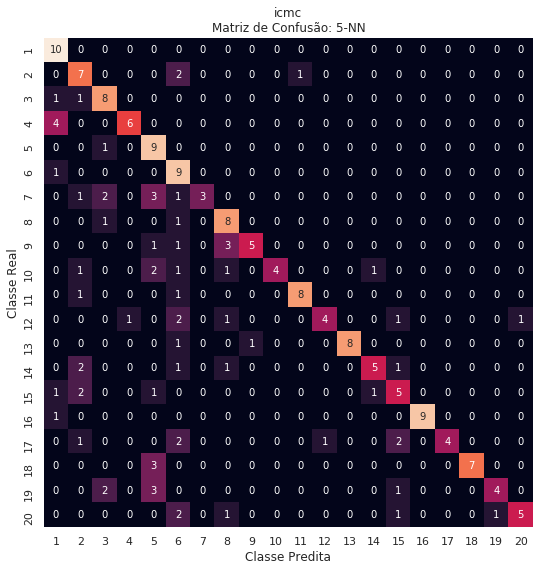

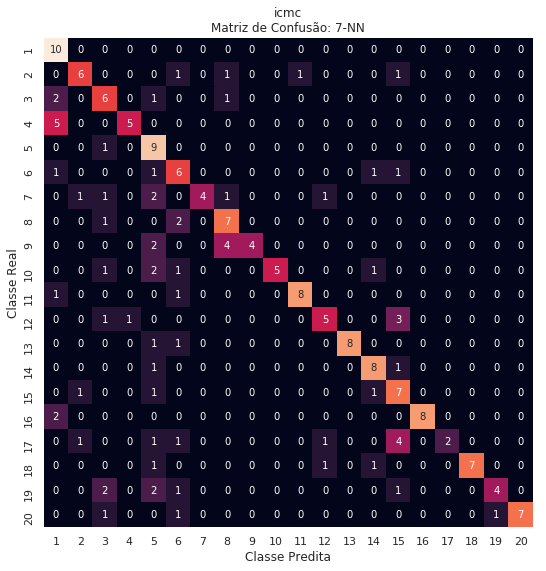

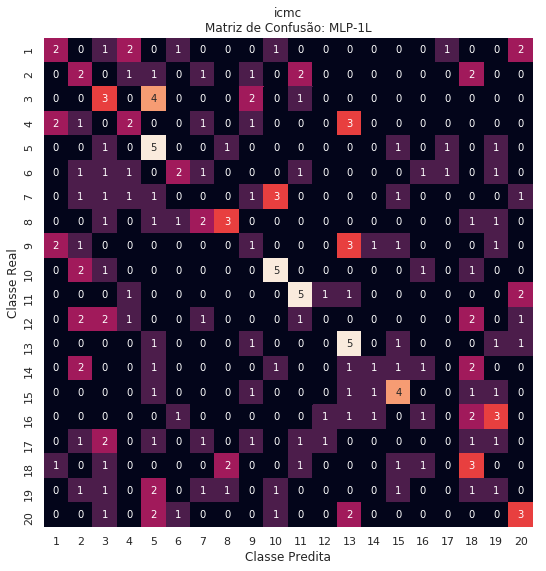

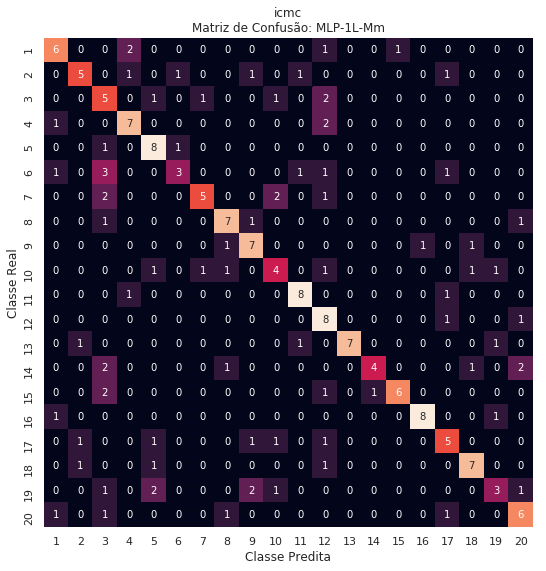

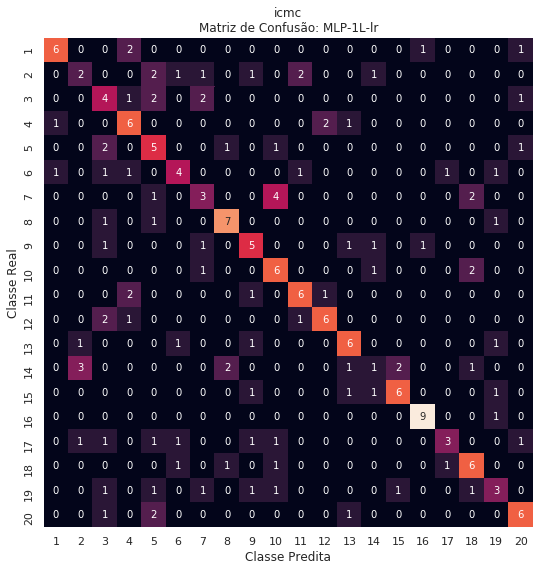

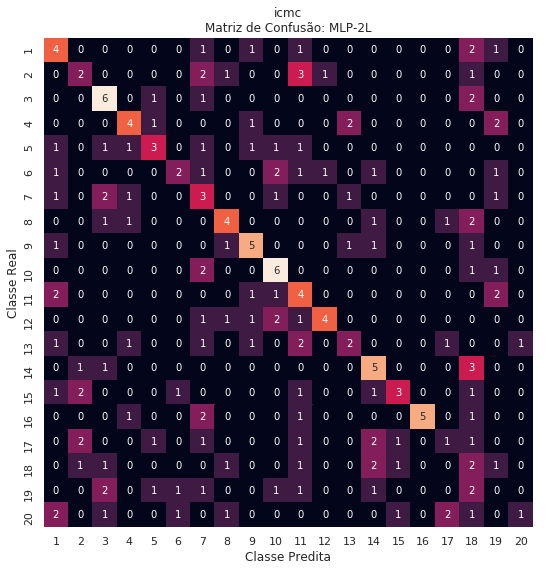

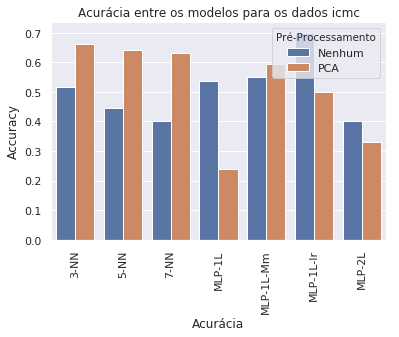

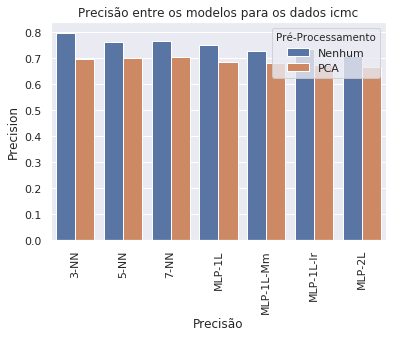

In [23]:
plot_result(icmc_matrix, name="icmc", use_hue=True, file_prefix="icmc_pca")

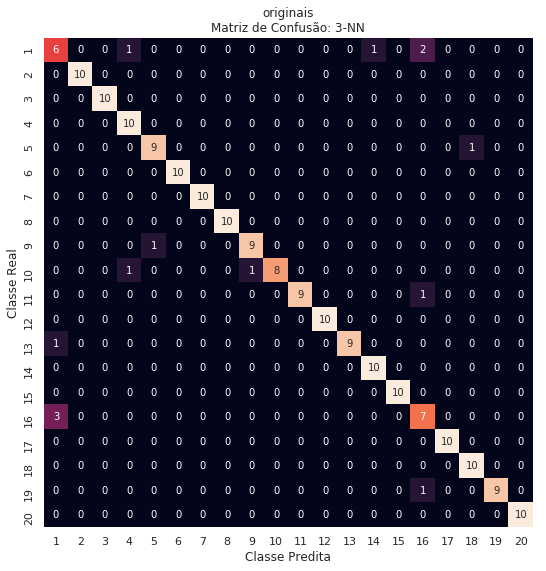

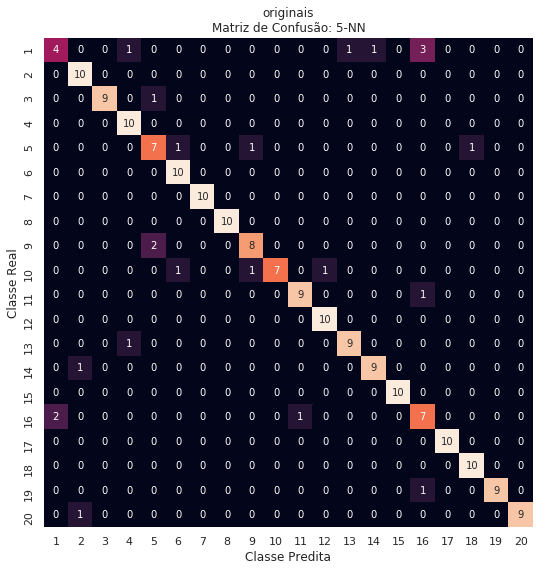

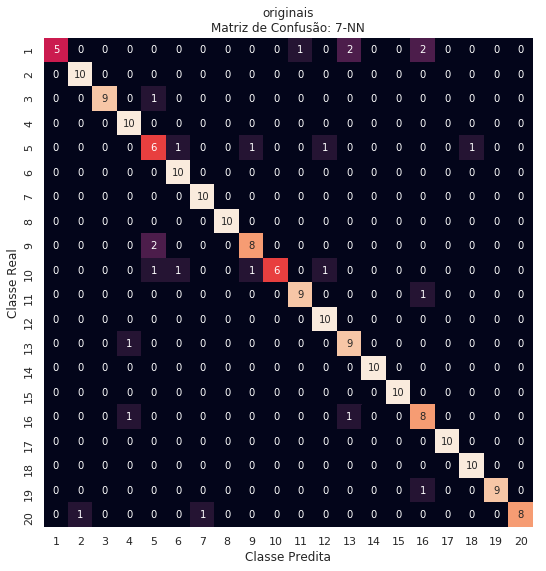

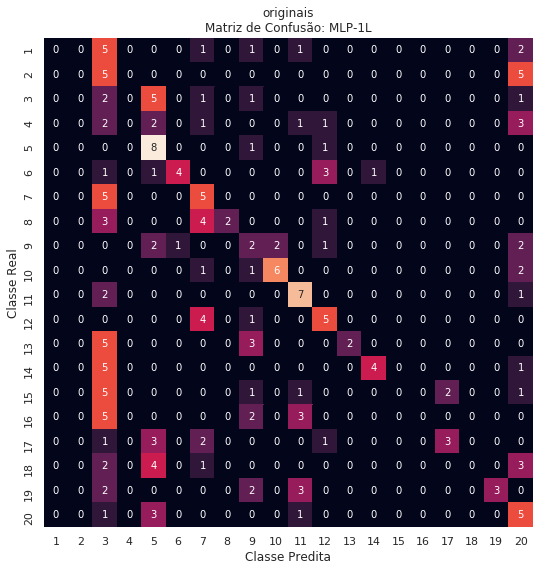

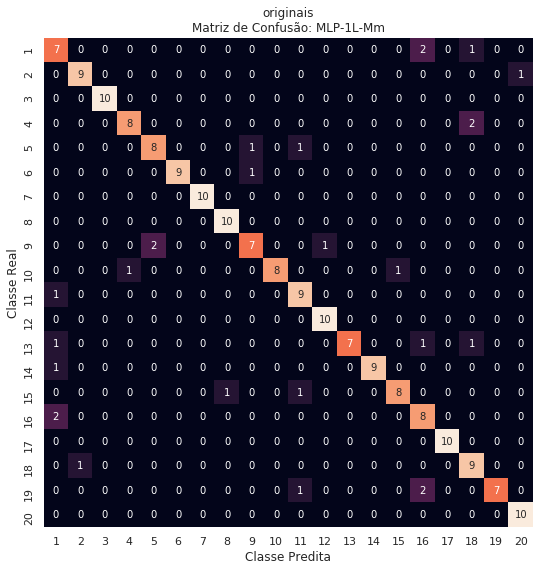

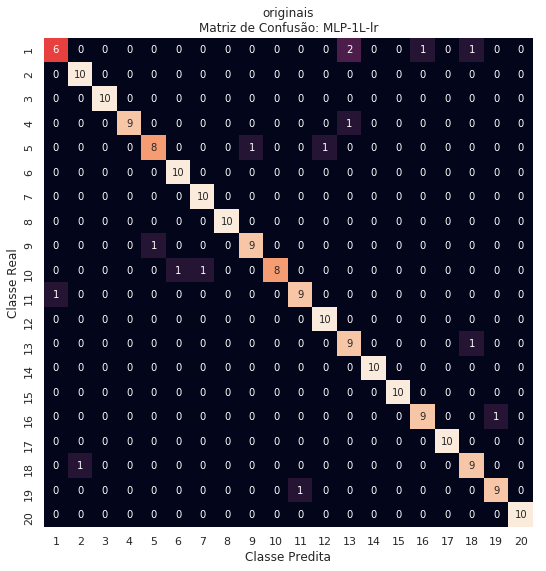

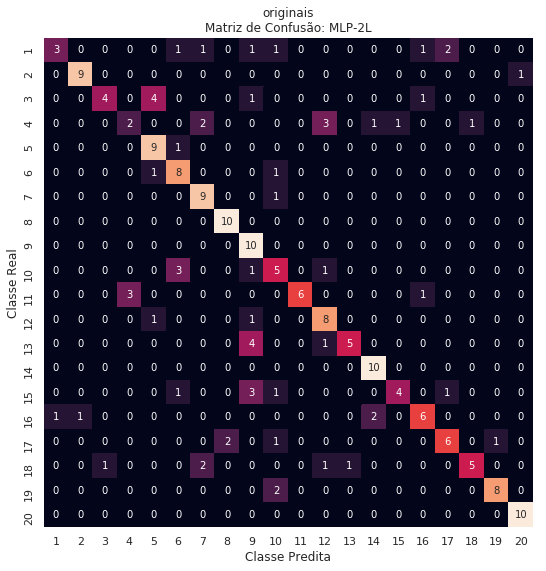

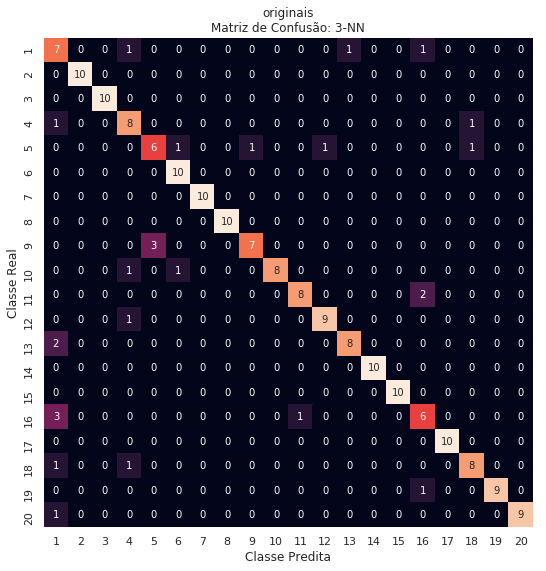

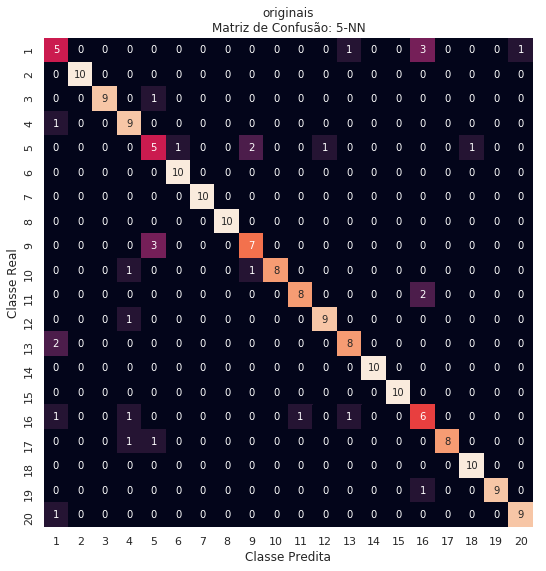

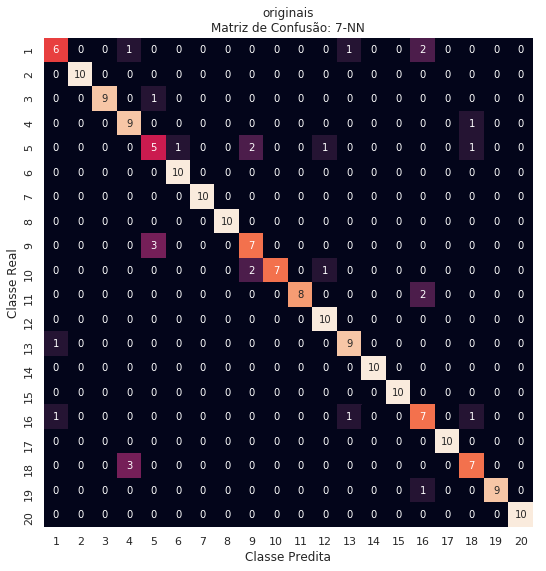

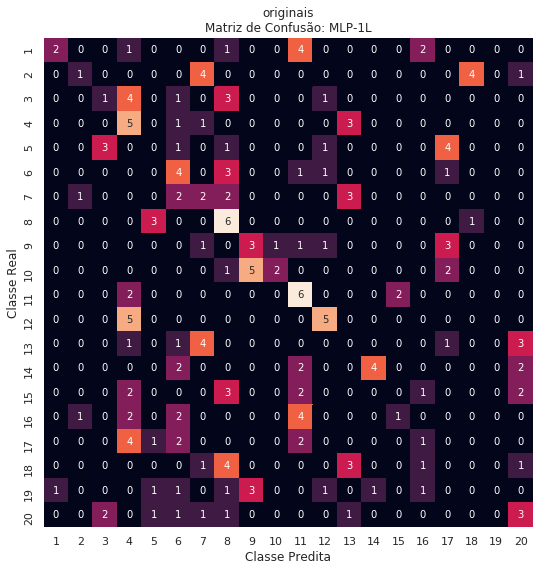

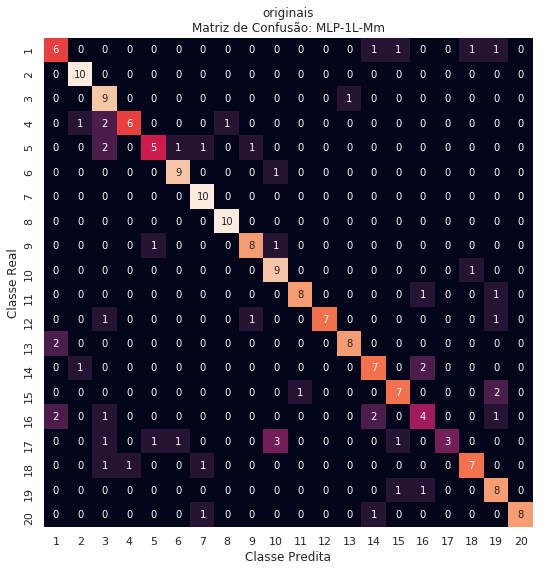

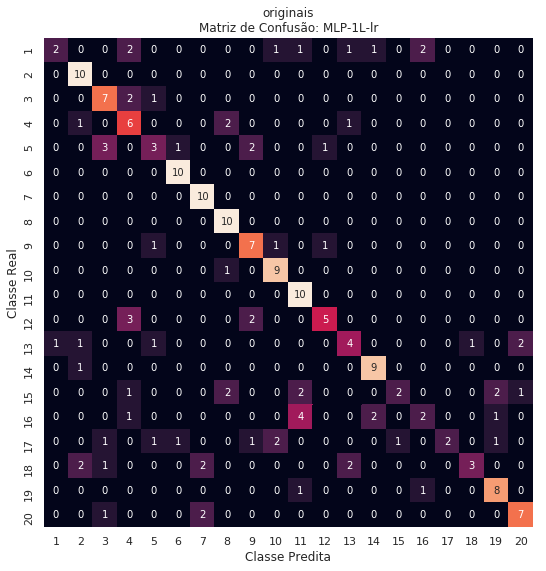

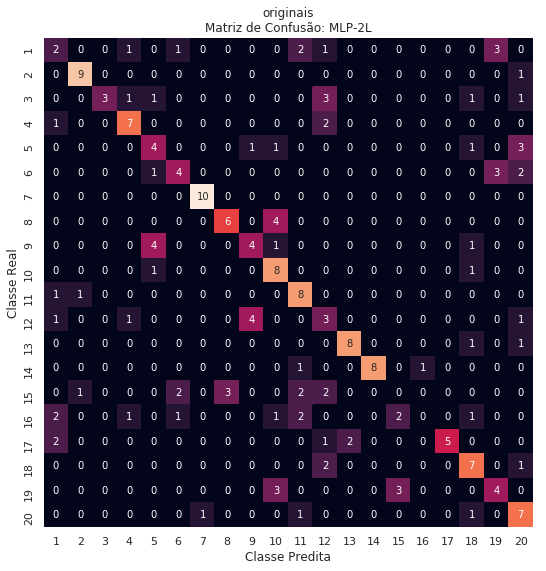

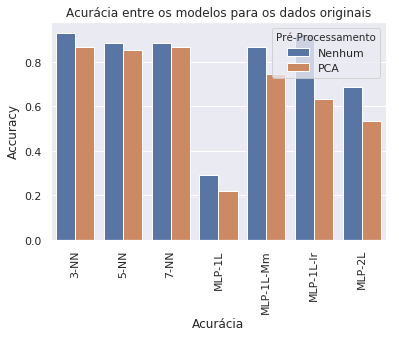

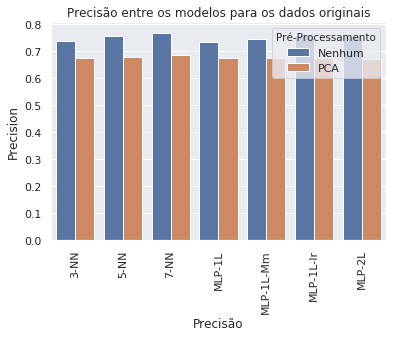

In [24]:
plot_result(original_matrix, name="originais", use_hue=True, 
            file_prefix="orl_pca")

In [28]:
print(icmc_matrix[['Accuracy', 'Precision', 'Model', 'Pré-Processamento']])

    Accuracy  Precision      Model Pré-Processamento
0      0.515   0.798919       3-NN            Nenhum
1      0.445   0.760691       5-NN            Nenhum
2      0.400   0.765707       7-NN            Nenhum
3      0.535   0.750561     MLP-1L            Nenhum
4      0.550   0.728404  MLP-1L-Mm            Nenhum
5      0.700   0.734521  MLP-1L-lr            Nenhum
6      0.400   0.709827     MLP-2L            Nenhum
7      0.660   0.698763       3-NN               PCA
8      0.640   0.701129       5-NN               PCA
9      0.630   0.703268       7-NN               PCA
10     0.240   0.684099     MLP-1L               PCA
11     0.595   0.682073  MLP-1L-Mm               PCA
12     0.500   0.675406  MLP-1L-lr               PCA
13     0.330   0.664842     MLP-2L               PCA


In [27]:
print(original_matrix[['Accuracy', 'Precision', 'Model', 'Pré-Processamento']])

    Accuracy  Precision      Model Pré-Processamento
0      0.930   0.737897       3-NN            Nenhum
1      0.885   0.754621       5-NN            Nenhum
2      0.885   0.768879       7-NN            Nenhum
3      0.290   0.733739     MLP-1L            Nenhum
4      0.865   0.746027  MLP-1L-Mm            Nenhum
5      0.925   0.759989  MLP-1L-lr            Nenhum
6      0.685   0.756879     MLP-2L            Nenhum
7      0.865   0.675055       3-NN               PCA
8      0.850   0.680052       5-NN               PCA
9      0.865   0.685154       7-NN               PCA
10     0.220   0.673633     MLP-1L               PCA
11     0.745   0.676089  MLP-1L-Mm               PCA
12     0.630   0.675322  MLP-1L-lr               PCA
13     0.535   0.672137     MLP-2L               PCA
